In [1]:
import pickle
import torch

In [114]:
def get_conf_scores(emb_dir):   
    res = pickle.load( open(emb_dir, 'rb') )
    act, pred, tar = res['act'], res['pred'], res['tar']
    sm = torch.nn.functional.softmax(act, dim=1)
    acc = ( pred == tar ).sum() / len(pred)

    print('averaged conf:', sm.max(1)[0].mean().item())
    print('acc:', acc.item())
    print()
    
    max_scores = sm.max(1)[0]
    ne_scores = torch.sum(sm * torch.log2(sm), dim=1)
    log_scores = ne_scores - (max_scores) * torch.log2( (max_scores) )
    
    return max_scores, ne_scores, log_scores, pred, tar

In [115]:
iid_emb = '../cache/CIFAR-10/resnet50_1-300/scratch/id_m1-300_d1.pkl'
novel_emb = f'../cache/CIFAR-10/resnet50_1-300/scratch/od_pnatural_m1-300_ccollection-0_n10000.pkl'
corr_emb = f'../cache/CIFAR-10/resnet50_1-300/scratch/od_psame_m1-300_cimpulse_noise-5_n10000.pkl'

In [116]:
iid_mc, iid_ne, iid_log, iid_pred, iid_tar = get_conf_scores(iid_emb)
novel_mc, novel_ne, novel_log, novel_pred, novel_tar = get_conf_scores(novel_emb)
corr_mc, corr_ne, corr_log, corr_pred, corr_tar = get_conf_scores(corr_emb)

averaged conf: 0.8860023617744446
acc: 0.8813999891281128

averaged conf: 0.8080294728279114
acc: 0.7461000084877014

averaged conf: 0.6608860492706299
acc: 0.350600004196167



In [117]:
n_incorrect = (iid_pred != iid_tar).sum()
n_correct = (iid_pred == iid_tar).sum()
t_mc = torch.sort(iid_mc)[0][n_incorrect - 1].item()
t_ne = torch.sort(iid_ne)[0][n_incorrect - 1].item()
t_log = torch.sort(iid_log)[0][n_incorrect - 1].item()

In [118]:
def get_error_estimates(shift, pred, tar, mc_scores, ne_scores, log_scores, t_mc, t_ne, t_log):
    print(shift)
    print('true error:', (pred != tar).sum().item() / len(tar))
    print('atc-mc pred corr error:', (mc_scores < t_mc).sum().item() / len(mc_scores) )
    print('atc-ne pred corr error:', (ne_scores < t_ne).sum().item() / len(ne_scores) )
    print('atc-log pred corr error:', (log_scores < t_log).sum().item() / len(log_scores) )
        

In [119]:
get_error_estimates('corr', corr_pred, corr_tar, corr_mc, corr_ne, corr_log, t_mc, t_ne, t_log)
get_error_estimates('novel', novel_pred, novel_tar, novel_mc, novel_ne, novel_log, t_mc, t_ne, t_log)

corr
true error: 0.6494
atc-mc pred corr error: 0.4364
atc-ne pred corr error: 0.4832
atc-log pred corr error: 0.4901
novel
true error: 0.2539
atc-mc pred corr error: 0.2186
atc-ne pred corr error: 0.2235
atc-log pred corr error: 0.2242


In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams

rcParams['figure.figsize'] = 5, 3

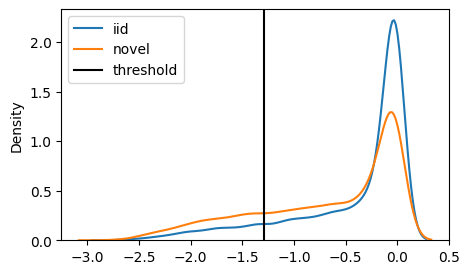

In [121]:
sns.kdeplot(iid_log, label='iid')
sns.kdeplot(novel_log, label='novel')
plt.axvline(x=t_log, color='black', label='threshold')
plt.legend()
plt.show()

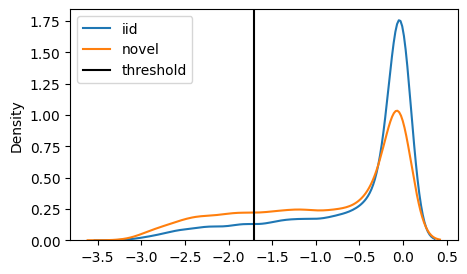

In [122]:
sns.kdeplot(iid_ne, label='iid')
sns.kdeplot(novel_ne, label='novel')
plt.axvline(x=t_ne, color='black', label='threshold')
plt.legend()
plt.show()

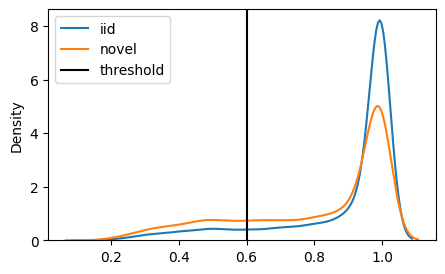

In [123]:
sns.kdeplot(iid_mc, label='iid')
sns.kdeplot(novel_mc, label='novel')
plt.axvline(x=t_mc, color='black', label='threshold')
plt.legend()
plt.show()

In [8]:
import matplotlib.pyplot as plt
import numpy as np

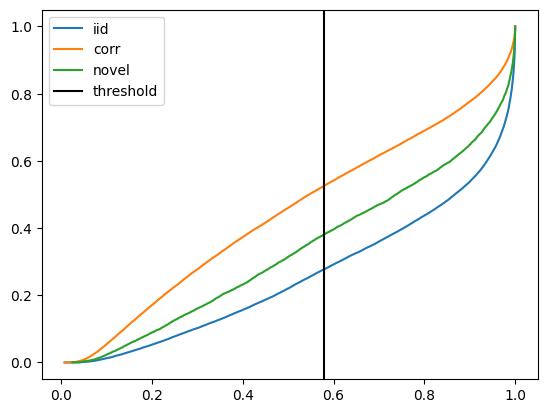

In [9]:
plt.plot(np.sort(iid_sm), np.cumsum(np.ones(len(iid_sm))) / len(iid_sm), label='iid')
plt.plot(np.sort(corr_sm), np.cumsum(np.ones(len(corr_sm))) / len(corr_sm), label='corr')
plt.plot(np.sort(novel_sm), np.cumsum(np.ones(len(novel_sm))) / len(novel_sm), label='novel')
plt.axvline(x=t, color = 'black', label='threshold')
plt.legend()
plt.show()

In [10]:
import seaborn as sns

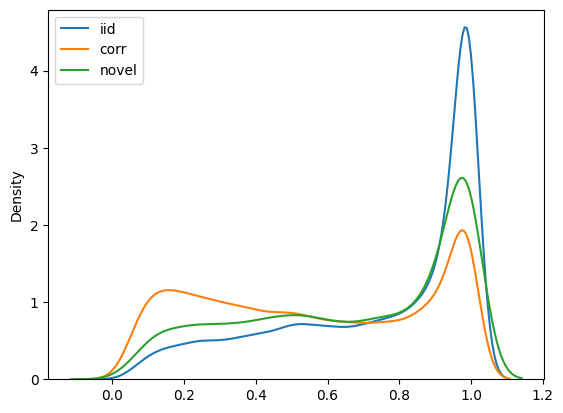

In [11]:
sns.kdeplot(np.array(iid_sm), label='iid')
sns.kdeplot(np.array(corr_sm), label='corr')
sns.kdeplot(np.array(novel_sm), label='novel')
plt.legend()
plt.show()

In [12]:
from scipy import integrate

In [13]:
def get_auc(sm):
    x = np.sort(sm)
    y = np.cumsum(np.ones(len(x)) / len(x))
    
    return 1 - integrate.simpson(y, x)

In [14]:
print('iid auc:', get_auc(iid_sm))
print('corr auc:', get_auc(corr_sm))
print('novel auc:', get_auc(novel_sm))

iid auc: 0.7461553119425206
corr auc: 0.5595708696709568
novel auc: 0.6704623328375066


In [15]:
import altair as alt
import pandas as pd

In [21]:
iid_sm_long = [{'confidence': cf.item(), 'shift': 'iid'} for cf in iid_sm]
corr_sm_long = [{'confidence': cf.item(), 'shift': 'corr'} for cf in corr_sm]
novel_sm_long = [{'confidence': cf.item(), 'shift': 'novel'} for cf in novel_sm]

sm_long = iid_sm_long + corr_sm_long + novel_sm_long
data = pd.DataFrame(sm_long)

In [22]:
data

confidence  shift
0         0.400662    iid
1         0.418061    iid
2         0.368213    iid
3         0.983504    iid
4         0.975640    iid
...            ...    ...
109995    0.873922  novel
109996    0.511243  novel
109997    0.681888  novel
109998    0.991975  novel
109999    0.994189  novel

[110000 rows x 2 columns]

In [23]:
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(data, width=120, height=80).transform_density(
    'confidence',
    groupby=['shift'],
    as_=['confidence', 'density'],
).mark_area().encode(
    x="confidence:Q",
    y='density:Q',
).facet(
    'shift:N'
)

/usr/workspace/lu35/anaconda3/envs/ood/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

Text(0.5, 1.0, 'Ridgeline Plot, multiple groups')

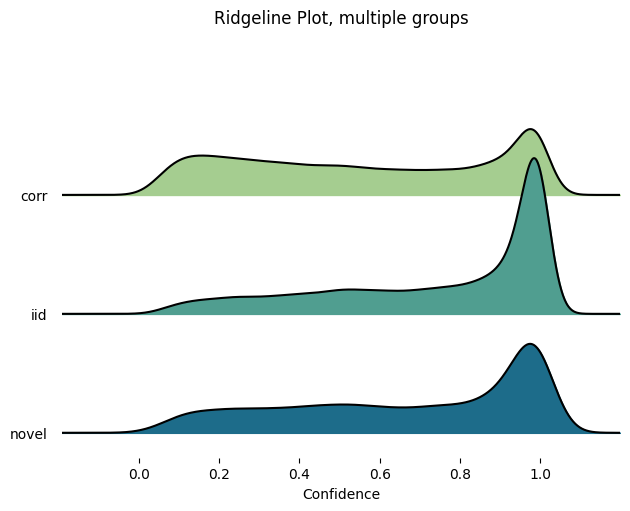

In [24]:
from joypy import joyplot

joyplot(data, by='shift', column='confidence', colormap=sns.color_palette("crest", as_cmap=True))
plt.xlabel('Confidence')
plt.title("Ridgeline Plot, multiple groups")

In [ ]:
import ot

In [ ]:
import altair as alt
import pandas as pd
import numpy as np

alt.data_transformers.enable('default', max_rows=None)

In [ ]:
iid_hist, _ = np.histogram(iid_sm, bins=[i/10 for i in range(11)])
corr_hist, _ = np.histogram(corr_sm, bins=[i/10 for i in range(11)])
novel_hist, _ = np.histogram(novel_sm, bins=[i/10 for i in range(11)])

In [ ]:
iid_dens = iid_hist / sum(iid_hist)
corr_dens = corr_hist / sum(corr_hist)
novel_dens = novel_hist / sum(novel_hist)

In [ ]:
def transform_data(dens, group):
    return [{'percent': i, 'conf': ind/10+0.05, 'group': group} for ind, i in enumerate(dens)]

In [ ]:
dens = transform_data(iid_dens, 'iid') + transform_data(corr_dens, 'corr') + transform_data(novel_dens, 'novel')

In [ ]:

alt.Chart(pd.DataFrame(dens)).mark_bar().encode(
    x=alt.X('conf:Q', bin=True),
    y=alt.Y('percent:Q'),
    column='group:N',
    color='group:N'
).properties(
    width=200,
    height=200
)